In [1]:
from cbt_preprocessing import CBTProcessor

# give path to text corpus and embeddings
data_loader = CBTProcessor('data/cbt_train.txt', 'data/glove.6B.50d.txt', 50)

Words extracted. Total number: 33012
Number of pre-trained: 32416


In [2]:
# prepare for batch generation on train and val splits
data_loader.fit_on_texts('data/cbtest_CN_train.txt', 'train')
data_loader.fit_on_texts('data/cbtest_CN_valid_2000ex.txt', 'val')

In [3]:
# check batch sampling
ex_batch_train = data_loader.sample_batch('train', 32)
data_loader.show_example(ex_batch_train)

DOC:
he little suspected , innocent youth that he was , that here , in this very athens , where his father reigned , a greater danger awaited him than any which he had encountered on the road . yet this was the truth . you must understand that the father of theseus , though not very old in years , was almost worn out with the cares of government , and had thus grown aged before his time . his nephews , not expecting him to live a very great while , intended to get all the power of the kingdom into their own hands . but when they heard that theseus had arrived in athens , and learned what a gallant young man he was , they saw that he would not be at all the kind of a person to let them steal away his father 's crown and scepter , which ought to be his own by right of inheritance . thus these nephews of king aegeus , who were the own cousins of theseus , at once became his enemies . a still more dangerous enemy was medea , the wicked enchantress ; for she was now the king 's wife , and w

In [4]:
# each batch contains:
# docs and queries
ex_D_train, ex_Q_train = ex_batch_train[0], ex_batch_train[1]
print('Doc shape:', ex_D_train.shape)
print('Query shape:', ex_Q_train.shape)
# 10 possible candidates
ex_C_train = ex_batch_train[2]
print('-'*10)
print('Cands shape:', ex_C_train.shape)
# real answers
ex_A_train = ex_batch_train[3]
print('-'*10)
print('Answer shape:', ex_A_train.shape)
# Doc2Query Masks
ex_mask_train = ex_batch_train[4]
print('-'*10)
print('Mask shape:', ex_mask_train.shape)

Doc shape: (32, 1000)
Query shape: (32, 150)
----------
Cands shape: (32, 10)
----------
Answer shape: (32,)
----------
Mask shape: (32, 1000, 150)


# Memory Network

In [5]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

In [26]:
tf.reset_default_graph()

X = tf.placeholder(tf.int32, [None, data_loader.max_doc_len], name='Doc')
q = tf.placeholder(tf.int32, [None, data_loader.max_query_len], name='Query')
a = tf.placeholder(tf.int32, [None,], name='Answer')

A_emb = tf.Variable(data_loader.embeddings, name='Doc_embeddings')
B_emb = tf.Variable(data_loader.embeddings, name='Query_embeddings')
C_emb = tf.Variable(data_loader.embeddings, name='Output_embeddings')

def one_hop(X, q, A_emb, B_emb, C_emb):
    m = tf.nn.dropout(tf.nn.embedding_lookup(A_emb, X, name='Memory_vector'), 0.8)
    u = tf.reduce_mean(tf.nn.dropout(tf.nn.embedding_lookup(B_emb, q), 0.8), 1, name='Internal_state')
    p = tf.nn.softmax(m @ tf.reshape(u, shape=(-1,data_loader.embed_dim,1)), axis=1, name='Match_prob')
    c = tf.nn.dropout(tf.nn.embedding_lookup(C_emb, X, name='Output_vector'), 0.8)
    
    return u, tf.reduce_sum(p * c, axis=1, name='Response_vector')

u, o = one_hop(X, q, A_emb, B_emb, C_emb)

a_hat_logits = tf.layers.dense(o+u, len(data_loader.words), use_bias=False)
a_hat = tf.nn.softmax(a_hat_logits)

train_loss = tf.losses.sparse_softmax_cross_entropy(a, a_hat_logits)
acc_score = tf.contrib.metrics.accuracy(tf.argmax(a_hat, axis=1, output_type=tf.int32), a)

optim = tf.train.AdamOptimizer(learning_rate=5e-3)
train_op = optim.minimize(train_loss)
print(a_hat.shape)

(?, 33012)


In [27]:
data_loader.train_data_len

120769

In [28]:
def get_accuracy(sess, data_loader, batch_size=100):
    total_acc = 0
    for step in range(0, data_loader.val_data_len, batch_size):
        batch_val = data_loader.sample_batch('val', batch_size, offset=step)
        
        iacc = sess.run(acc_score, feed_dict={X:batch_val[0], q:batch_val[1], a:batch_val[3]})
        total_acc += iacc * batch_size
    return total_acc / data_loader.val_data_len

In [29]:
batch_size = 50
steps_per_epoch = 400
n_epochs = 20

train_losses = []
train_accs = []
val_accs = []
bs = 0

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in tqdm(range(n_epochs)):
    print('-'*10)
    print('EPOCH:', epoch)
    
    ctrain_loss, ctrain_accuracy = 0, 0
    cval_accuracy = 0
    
    for step in range(steps_per_epoch):
        batch_train = data_loader.sample_batch('train', batch_size)
        
        _, iloss, iacc = sess.run([train_op, train_loss, acc_score], 
                                    feed_dict={X: batch_train[0], q: batch_train[1], a: batch_train[3]})
        
        ctrain_loss += iloss
        ctrain_accuracy += iacc
    
    ctrain_loss /= steps_per_epoch
    ctrain_accuracy /= steps_per_epoch
    cval_accuracy = get_accuracy(sess, data_loader)
    
    train_losses += [ctrain_loss]
    train_accs += [ctrain_accuracy]
    val_accs += [cval_accuracy]
    
    print('Train cross-entropy loss:', ctrain_loss)
    print('Train accuracy:', ctrain_accuracy)
    print('Val accuracy:', cval_accuracy)
    if len(val_accs) > 5 and cval_accuracy < np.mean(val_accs[-5:]):
        bs += 1
        if bs >= 3:
            print('Finished')
            break


  0%|          | 0/20 [00:00<?, ?it/s]

----------
EPOCH: 0



Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  5%|▌         | 1/20 [04:30<1:25:43, 270.72s/it]

Train cross-entropy loss: 6.946855664253235
Train accuracy: 0.03549999928101897
Val accuracy: 0.054999999981373546
----------
EPOCH: 1


 10%|█         | 2/20 [08:41<1:18:14, 260.83s/it]

Train cross-entropy loss: 6.222373688220978
Train accuracy: 0.07039999919943511
Val accuracy: 0.10149999987334013
----------
EPOCH: 2


 15%|█▌        | 3/20 [12:55<1:13:15, 258.54s/it]

Train cross-entropy loss: 5.772570456266403
Train accuracy: 0.10794999959878623
Val accuracy: 0.12149999979883433
----------
EPOCH: 3


 20%|██        | 4/20 [16:59<1:07:59, 254.99s/it]

Train cross-entropy loss: 5.416052341461182
Train accuracy: 0.1312499996740371
Val accuracy: 0.14149999767541885
----------
EPOCH: 4


 25%|██▌       | 5/20 [21:32<1:04:36, 258.43s/it]

Train cross-entropy loss: 5.1719905638694765
Train accuracy: 0.14899999951943754
Val accuracy: 0.15650000125169755
----------
EPOCH: 5


 30%|███       | 6/20 [25:48<1:00:12, 258.01s/it]

Train cross-entropy loss: 4.962074965238571
Train accuracy: 0.16670000000856816
Val accuracy: 0.13950000070035457
----------
EPOCH: 6


 35%|███▌      | 7/20 [29:12<54:13, 250.30s/it]  

Train cross-entropy loss: 4.777572450041771
Train accuracy: 0.17780000001192092
Val accuracy: 0.15199999921023846
----------
EPOCH: 7


 40%|████      | 8/20 [32:31<48:47, 243.94s/it]

Train cross-entropy loss: 4.58633693933487
Train accuracy: 0.18520000005140902
Val accuracy: 0.1474999997764826
----------
EPOCH: 8


 45%|████▌     | 9/20 [35:44<43:41, 238.30s/it]

Train cross-entropy loss: 4.49972744345665
Train accuracy: 0.19989999961107968
Val accuracy: 0.14650000259280205
----------
EPOCH: 9


 50%|█████     | 10/20 [38:57<38:57, 233.80s/it]

Train cross-entropy loss: 4.3061861926317215
Train accuracy: 0.21759999959729612
Val accuracy: 0.15500000044703482
----------
EPOCH: 10


 55%|█████▌    | 11/20 [42:01<34:23, 229.23s/it]

Train cross-entropy loss: 4.209929571151734
Train accuracy: 0.22469999960623682
Val accuracy: 0.15899999886751176
----------
EPOCH: 11


 60%|██████    | 12/20 [44:56<29:57, 224.72s/it]

Train cross-entropy loss: 4.038405809998512
Train accuracy: 0.24119999948889018
Val accuracy: 0.14549999870359898
----------
EPOCH: 12


 65%|██████▌   | 13/20 [47:55<25:48, 221.21s/it]

Train cross-entropy loss: 3.958356201052666
Train accuracy: 0.25175000039860607
Val accuracy: 0.15350000001490116
----------
EPOCH: 13


 70%|███████   | 14/20 [50:54<21:49, 218.20s/it]

Train cross-entropy loss: 3.836171643137932
Train accuracy: 0.2701500001363456
Val accuracy: 0.15500000156462193
----------
EPOCH: 14


 75%|███████▌  | 15/20 [53:59<17:59, 215.94s/it]

Train cross-entropy loss: 3.7081448185443877
Train accuracy: 0.2826000002026558
Val accuracy: 0.1544999998062849
----------
EPOCH: 15
Train cross-entropy loss: 3.6255783182382584
Train accuracy: 0.2921500005014241
Val accuracy: 0.14649999998509883
Finished


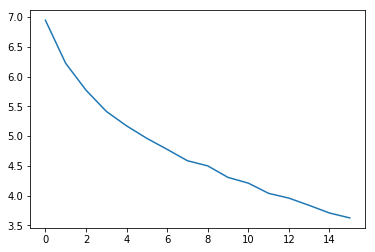

In [30]:
from matplotlib import pyplot as plt

plt.plot(train_losses)
plt.show()

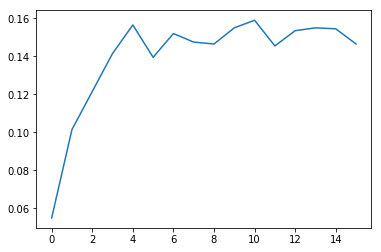

In [31]:
plt.plot(val_accs)
plt.show()

In [95]:
example_val = data_loader.sample_batch('val', 1)
ex_hat = sess.run(a_hat, feed_dict={X:example_val[0], q:example_val[1]})

data_loader.show_example(example_val)

DOC:
at these words she struck the ground with her foot and a gulf opened , down which they went right into the heart of the earth . in a short time they reached 's palace , which gives light , with a light brighter than the sun , to the dark kingdoms below . and the prince , as he had been bidden , entered boldly into the hall . , with a shining crown upon his head , sat in the centre upon a golden throne . his green eyes glittered like glass , his hands were as the claws of a crab . when he caught sight of the prince he uttered piercing yells , which shook the walls of the palace . the prince took no notice , but continued his advance on his knees towards the throne . when he had almost reached it , the king broke out into a laugh and said : ` it has been very lucky for you that you have been able to make me laugh . stay with us in our underground empire , only first you will have to do three things . to-night it is late . go to sleep ; to-morrow i will tell you . ' early the followi

In [96]:
inds = ex_hat[0].argsort()[-5:][::-1]

print('Predictions:')
for ind in inds:
    print('Word:', data_loader.id_to_word[ind], '\t Score:', ex_hat[0][ind])

Predictions:
Word: room 	 Score: 0.06715854650833165
Word: palace 	 Score: 0.04113510202611516
Word: hall 	 Score: 0.03663513497483599
Word: prince 	 Score: 0.023544221653554905
Word: princess 	 Score: 0.02156811182835556
